# Performing a flood frequency analysis for the Lamprey and Sugar Rivers, NH
### ESCI 895 Final Project Fall 2021
### Lauren K

### 1.0 Introduction

Flood frequency analyses are used to estimate the return period, or exceedance probability, for flood magnitudes in a river. A return period is the average amount of time expected between extreme events. An exceedance probability is the likelihood of a certain magnitude event being reached or exceeded. The return period is the inverse of the exceedance probability. Flood frequency analyses methods use historic discharge measurements to predict flood magnitudes often only reached a few times or not at all within the flood record. Determining the likelihood of a certain magnitude flood occurring is important for adequately planning for future floods. Large floods endanger lives and destroy infrastructure if not prepared for sufficiently. Engineers can use exceedance probabilities to design infrastructure capable of withstanding certain flood magnitudes. Bridges are often designed to be capable of withstanding a 0.1% exceedance probability size flood, also called a 1000-year flood. Insurance companies use exceedance probabilities to determine which houses need flood insurance, often depending on if they are located within the floodplain of the 100-year flood. Due to the need for accurate estimation of flood magnitudes multiple methods of flood frequency analyses have been developed.

   Different flood frequency analysis methods have been created for use on both annual maximum discharge data and instantaneous discharge data sets. Annual maximum data is often used for flood frequency analysis but has some limitations (Bezak et al., 2014). Annual maximum data record lengths are usually quite small, often less than 100 values. Also, large flood events can be excluded from the record if they happen within the same year as a larger flood, as only the maximum value for the year is used. Some smaller flood magnitudes can also be recorded in the annual maximum in drought years with low flow levels overall. These can lead to less accurate estimates of flood magnitudes for certain exceedance probabilities (Pan and Rahman, 2021). For these reasons instantaneous discharge data may be preferred.

   Instantaneous discharge data avoids the limitations associated with annual maximum data but requires extra processing for use in flood frequency analysis. Often only extreme events are used in flood frequency analyses, but instantaneous data includes all flow values large and small. To account for this, a Peaks-Over-Threshold (POT) method is used with instantaneous data. This method only uses floods over a certain threshold magnitude for the flood frequency analysis. Threshold selection greatly impacts the results of the analysis and if the threshold is not selected accurately the accuracy of the analysis can be questioned. There multiple methods of determining a threshold analysis, often a mean residual plot can be created for use in threshold selection (Pan and Rahman, 2021). Other studies recommend using the flood magnitude of the 1.5-year flood as the threshold or a value that is at least equal to the minimum annual maximum event, so there are at least one to two discharge values used in the analysis for each year in the record (Bezak, 2017). The best method for threshold selection is still up for debate.
    
   There are many flood frequency analysis techniques that can be used on a variety of data sets (Stedinger et al., 1993). A few common techniques used on annual maximum data sets are the Log-Pearson Type III, the Generalized Extreme Value (GEV) Distribution, and the Gumbel distribution which is a type of GEV distribution. GEV distributions best fit the tail end of a normal distribution, meaning they are best suited towards extreme events, such as large floods. A different method, the Generalized Pareto Distribution (GPD) is often coupled with instantaneous data the POT method (Pan and Rahman, 2021). The GPD is well suited to model data over a selected threshold (Stedinger et al., 1993). 
    
   There are multiple methods that can be used to fit these distributions to data sets, including method of moments, method of maximum likelihood, and method of L moments (L-moments). One of the more robust and least biased methods is L-moments due to the technique using linear combinations of the data, rather than squaring or cubing the data (Stedinger et al., 1993). Some flood frequency analysis methods are more suited to some data sets while not being appropriate for others, often depending on the distribution of the data itself (Pan and Rahman, 2021).
    
   The goal of this project is to determine the flood magnitudes associated with the 2, 5, 10, 25, 50, and 100-year floods on the Lamprey and Sugar Rivers in New Hampshire. Both annual maximum and instantaneous discharge data will be analyzed for each river. Gumbel and GEV distributions will be fit to the annual maximum data. The POT and GPD method will be applied to the instantaneous discharge data for each river. Results of the methods will be compared and discussed.



### 2.0 Study Sites and Data Acquisition

#### 2.1 Lamprey River

The Lamprey River is located in Rockingham County, New Hampshire. The Lamprey River is 47 miles long, flowing from Northwood, NH to Newmarket, NH where it empties into the Great Bay. The Lamprey River has a 212 square mile watershed comprising of forest (73%), agriculture (5%), urban (7%), and wetlands (10%) (Wymore et al., 2021). Data was collected at a USGS station (01073500) located in Newmarket, NH. The gauge station is located upstream of Packer’s Falls. The drainage area upstream of the flow gauge is 185 square miles. The Lamprey River is regulated in part by Pawtuckaway Lake and Mendums Pond. The town of Durham also diverts water from the Lamprey for their municipal water supply (USGS). This station has 85 years of annual maximum discharge data (1935 – 2020) and 31 years of instantaneous discharge data (1990 – 2021). The instantaneous data was recorded at 1-hour intervals and more recently at 15-minute intervals.

![alt text](Lamprey.png "Lamprey River Watershed")
Figure 1. Map of the Lamprey River Watershed with the location of the USGS gauge marked with a red star (adapted from NHDES).

#### 2.2 Sugar River

The Sugar River is located in Sullivan County, New Hampshire. The river originates in Sunapee, NH, and runs for 27-miles west through Newport and Claremont, NH before emptying into the Connecticut River. The USGS gauge used in this project is in West Claremont, NH upstream of a small waterfall and a few miles downstream of a large waterfall located in Claremont, NH. The gauge has a station identification number of USGS 011052500. The area of the watershed upstream of the gauge is 269 square miles (USGS). The Sugar River is regulated by Sunapee Lake and occasionally diverted by mills upstream. This station has 91 years of annual maximum discharge data (1929 – 2020) and 31 years of instantaneous discharge data (1990 – 2021). The instantaneous data was recorded at 30-minute intervals and more recently at 15-minute intervals.

![alt text](Sugar.png "Sugar River Watershed")
Figure 2. Map of the Sugar River Watershed with the location of the USGS gauge marked with a red star (adapted from USDA-NWQI).

### 3.0 Methods

Data was analyzed using python (3.8.12). Neccessary libraries were imported.

In [83]:
#%% Import libraries
import numpy as np
from matplotlib import pyplot as plt
import math
from scipy.special import gamma, factorial
from scipy.signal import argrelextrema
import pandas as pd

 Input data files were specified and removed from Zip file format if needed.

In [84]:
#Instant files were too big to upload to Github, so need to extract them from zip files
from zipfile import ZipFile
with ZipFile('SugarInstant.zip', 'r') as zip:
    zip.extract('SugarInstant.txt')
with ZipFile('LampreyInstant.zip', 'r') as zip:
        zip.extract('LampreyInstant.txt')
#%% Specify inputs (instant, instant, annual, annual)
filenames = ['LampreyInstant.txt', 'SugarInstant.txt', 'LampreyAnnual.txt', 'SugarAnnual.txt']
#%% Names of rivers to be used in titles of plots
rivers = ['Lamprey River', 'Sugar River'] 

Raw Annual Maximum data was processed for each river. Unnecessary data was removed

In [85]:
#Create a function for data processing of annual data
def annualdataprocess(file):
    dfannual = pd.read_csv(file, delimiter="\t", comment='#', header=1, parse_dates=['10d'])
    #rename columns
    dfannual = dfannual.rename(columns={"10d": "DATE","8s": "annual_discharge_cfs"})
    #set date as index
    dfannual = dfannual.set_index('DATE')
    #Remove unneccesary columns
    dfannual = dfannual[['annual_discharge_cfs']]
    return dfannual

Instantaneous discharge data was processed for each river. Unnecessary data was removed and gaps in the data were filled through linear interpolation.

In [86]:
#Create a function for data processing of instantaneous data
def peakdataprocess(file):
    #Load discharge file into dfpeak
    #Bad data values are set to NaNs
    dfpeak = pd.read_csv(file, delimiter="\t", comment='#', header=1, parse_dates=['20d'], na_values = (9999, 999, 997,"Ice", "Eqp"))
    #Rename columns
    dfpeak = dfpeak.rename(columns={"20d": "DATE","14n": "discharge_cfs"})
    #Set date column as index
    dfpeak =dfpeak.set_index('DATE')
    #Remove not needed columns
    dfpeak = dfpeak[['discharge_cfs']]
    #Make sure all values are numbers
    dfpeak['discharge_cfs'] = pd.to_numeric(dfpeak['discharge_cfs'])
    #Fill nan values through linear interpolation
    dfpeak.interpolate(method = 'linear',inplace = True)
    return dfpeak

Raw data is shown in the tables below.

In [87]:
print(annualdataprocess(filenames[2]))

            annual_discharge_cfs
DATE                            
1935-01-11                  1820
1936-03-20                  5490
1937-02-24                  1940
1938-07-31                  3530
1939-04-20                  1890
...                          ...
2016-02-27                  1220
2017-04-07                  2200
2018-04-18                  1960
2018-11-05                  2070
2019-12-16                  2000

[86 rows x 1 columns]


Table 1. Annual maximum data for the Lamprey River.

In [88]:
print(peakdataprocess(filenames[0]))

                     discharge_cfs
DATE                              
1990-10-01 02:00:00           57.0
1990-10-01 03:00:00           57.0
1990-10-01 04:00:00           57.0
1990-10-01 05:00:00           56.0
1990-10-01 06:00:00           56.0
...                            ...
2021-09-30 22:45:00           85.3
2021-09-30 23:00:00           85.3
2021-09-30 23:15:00           85.3
2021-09-30 23:30:00           85.3
2021-09-30 23:45:00           85.3

[857256 rows x 1 columns]


Table 2. Raw instantaneous discharge data for the Lamprey River.

In [89]:
print(annualdataprocess(filenames[3]))

            annual_discharge_cfs
DATE                            
1929-03-23                  3440
1930-03-08                  3310
1931-04-11                  3380
1932-04-12                  4080
1933-04-18                  6530
...                          ...
2016-02-25                  4000
2017-02-26                  3590
2017-10-30                  3830
2018-12-22                  4280
2019-12-14                  2790

[92 rows x 1 columns]


Table 3. Annual maximum data for the Sugar River.

In [90]:
print(peakdataprocess(filenames[1]))

                     discharge_cfs
DATE                              
1990-10-01 00:01:00          148.0
1990-10-01 00:31:00          151.0
1990-10-01 01:01:00          151.0
1990-10-01 01:31:00          155.0
1990-10-01 02:01:00          155.0
...                            ...
2021-09-30 22:45:00          188.0
2021-09-30 23:00:00          188.0
2021-09-30 23:15:00          188.0
2021-09-30 23:30:00          188.0
2021-09-30 23:45:00          188.0

[795168 rows x 1 columns]


Table 4. Raw instantaneous discharge data for the Sugar River.

#### 3.1 Using Annual Maximum Data with GEV and GUMEL distributions

Annual maximum data was ranked by magnitude. Exceedance probabilities (EP) and return periods were calculated for the data using the Weibull plotting position formula shown below (Stedinger et al., 1993).

EP = r/(1+n)

Where r is rank (with rank of 1 being the largest), and n being the sample size. Then return periods were calculated by taking the inverse of the exceedance probabilities.

Next, L-moments were calculated using probability-weighted moment (PWM) equations listed below (Stedinger et al., 1993). The n variable represents the rank of the recorded peak discharge, Xj.

B1 = ∑(j=1)^(n-1)[(n-j)Xj/(n(n-1))]

B2 =∑(j=1)^(n-2)[(n-j)(n-j-1)Xj/(n(n-1)(n-2))]

λ1 = X-bar

λ2 = 2B1 – λ1

λ3 = 6B2 – 6B1 + λ1

Then the data was analyzed using the GEV distribution. The GEV distribution was chosen due to its ability to fit the extreme ends of a distribution of data suiting itself to flood frequency analysis of extreme floods. Variables c and k were calculated using the l-moment values to determine α and xi to be entered into the GEV equation listed below, where x is equal to a discharge that happens at a certain frequency, F, which is equal to one minus the exceedance probability (Stedinger et al., 1993).

x= ξ + (α/k)*(1 -(-ln⁡F)^k)

c = (2 λ2)/( λ3 + 3 λ2) – ln(2)/ln(3) 

k = 7.859c + 2.9554c2 

α = (k λ2)/(gamma(1+k)(1-2-k)) 

ξ = λ1 + (α/k)(gamma(1+k)-1)

Then the annual maximum data was analyzed using the Gumbel distribution, which is also known as GEV Type I. The Gumbel distribution was chosen for this project as it is a commonly used distribution for predicting the exceedance probabilities of large natural disasters, such as major floods, and in fitting data sets of maximums values, like the annual maximum data sets used within this project. The variables α and ξ where then determined and used in the Gumbel distribution equation shown below. In this equation x is equal to a discharge that happens at a certain frequency, F, which is equal to one minus the exceedance probability (Stedinger et al., 1993).

x= ξ + a*ln(- ln F)

α = λ2/ln(2) ξ = λ1 – 0.5772 α


In [105]:
def GEVandGUMBEL(file):
    #file = raw annual maximum data file
    #read file
    dfannual = annualdataprocess(file)
    
    #Find EP for peaks df
    count = dfannual['annual_discharge_cfs'].count()
    dfannual = dfannual.sort_values('annual_discharge_cfs', ascending = True)
    dfannual['rank'] = dfannual['annual_discharge_cfs'].rank(ascending= False)
    #Use weibell formula of EP = rank/(sample size + 1)
    dfannual['EP'] = dfannual['rank']/(count+1)
    #Calculate resturn period as return period = 1/EP
    dfannual['Return Period'] = 1/dfannual['EP']
    
    #Create a dataframe with return periods
    interp = np.array([1.5,2,5,10,25,50,100,200,500,1000])
    dfinterp = pd.DataFrame(interp, columns=['Return Period (yrs)'])
    
    #Calculate exceedence probablity from return periods
    dfinterp['EP'] = round(1/dfinterp['Return Period (yrs)'],4)
    #Create a 1-EP column for Gumbel and GEV using L-moments
    dfinterp['1 - EP'] = 1 - dfinterp['EP']
    #Set index to return period
    dfinterp = dfinterp.set_index('Return Period (yrs)')

    
    #Calculate L moments - equations from Stedinger et al., 1993
    #calculate record length
    num = len(dfannual)
    #Sort dfannual so largest are on top by rank
    dfannual = dfannual.sort_values(by = 'rank', ascending = True)
    #calculate b1 for each discharge value
    dfannual['b1'] = ((num-dfannual['rank'])/(num*(num-1)))*dfannual['annual_discharge_cfs']
    #calculate b2 for each discharge value
    dfannual['b2'] = (((num-dfannual['rank'])*(num-dfannual['rank']-1))/(num*(num-1)*(num-2)))*dfannual['annual_discharge_cfs']
    #Calulate B1 and B2 by summing b1 and b2 columns
    B1 = sum(dfannual['b1'])
    B2 = sum(dfannual['b2'])
    
    #calulate l-moments - equations from Stedinger et al., 1993
    lamda1 = np.mean(dfannual['annual_discharge_cfs'])
    lamda2 = 2*B1-lamda1
    lamda3 = 6*B2-6*B1+lamda1
    skew = lamda3/lamda2
    
    #Calulate constants for GEV - equations from Stedinger et al., 1993
    c = 2*lamda2/(lamda3+3*lamda2)-np.log(2)/np.log(3)
    k = 7.859*c+2.9554*c**2
    alpha = (k*lamda2)/(gamma(1+k)*(1-2**(-k)))
    squiggle = lamda1 + (alpha/k)*(math.gamma(1+k)-1)
    #print(c , k , alpha, squiggle)
    
    #Use equation for GEV to calculate discharge predictions for each return period
    dfinterp['GEV'] = round(squiggle+(alpha/k)*(1-(-np.log(dfinterp['1 - EP']))**k),3) #cfs
    
    #GUMBEL - calculate constants
    alphagum = lamda2/np.log(2)
    squigglegum = lamda1-0.5772*alphagum
    #Use equation for Gumbel to calculate discharge estimates for each return period.
    dfinterp['Gumbel'] = round(squigglegum-alphagum*np.log(-np.log(dfinterp['1 - EP'])),3) #cfs
    return dfinterp, dfannual
    print(dfinterp)
    

#### 3.2 Analyzing Instantaneous Data Using POT and GPD

Instantaneous data was checked for errors and missing data which were replaced using interpolation. A threshold was set to equal the lower of the 1.5-year flood magnitude flood estimates calculated using the GEV and Gumbel methods for each river (Bezak, 2017). Next, a peak magnitude was selected for each individual flood event which exceeded the threshold discharge. The remaining values were then used for the flood frequency analysis. Similar to the procedure for GEV and Gumbel, exceedance probabilities and return periods were calculated using the Weibull equation for each peak value (Stedinger et al., 1993).

The GPD analysis was completed. L-moments were calculated for the data using the same PWM and L-moment equations as used for the GEV and Gumbel distributions. L-moments were chosen due to their robust nature and low bias (Stedinger et al., 1993). Then variables k and α were calculate using the equations shown below where ξ represents the chosen threshold. In the GPD equation, x is equal to the discharge value predicted for an event that happens at some frequency, F, which is equal to one minus the exceedance probability (Stedinger et al., 1993).

x= ξ + (α/k) (1 -(1-F)^k )

k = (λ1 - ξ )/ λ2 - 2 

α = (λ1 - ξ)/(1+k)

The probability density function (PDF) and cumulative density function (CDF) were calculated for each data set using previously calculated variables and equations presented in Stedinger et al., 1993. These equations are shown below. A plot of these curves was created.

PDF:
f(x) = (1/α)[1 - k((x - ξ)/α)]^((1/k - 1)

CDF:
F(x) = 1 - [1 - k((x - ξ)/α)]^(1/k)


In [106]:
def GPD(file, threshold, rangelower, rangeupper, inc, river):
    #file = input raw instaneous discharge data (this function will replace bad data and NaNs using interpolation)
    #threshold = Only peaks above this value are analyzed, the rest of the values are discarded. 
                 #Suggest using 1-2 yr flood magnitude for the simplest method of threshold selection)
    #rangelower = value needs to be above threshold, and it used to develop the cdf/pdf curves
    #rangeupper = used to develop the cdf/pdf curves, no limit but should end up being a value expected for the 1000-yr flood
    #inc = increment between rangelower and rangeupper for cdf/pdf (select a inc that gives you 20-30 values between rangelower and rangeupper)
    #river = name of river to title plots with (can select a value from the rivers list created earlier in the code)

    #POT method - select the max value per each storm event and remove extra values above the threshold within a single event
    #Create a new df peaks with all the peak values
    #This function selects peaks within the data within the surronding 100 values.
    dfpeak = peakdataprocess(file)
    peaks = dfpeak.iloc[argrelextrema(dfpeak['discharge_cfs'].values, np.greater_equal, order = 100 )]
    #Drop all values below the threshold which are not needed for the extreme events analysis.
    peaks.drop(peaks[peaks['discharge_cfs'] < threshold].index, inplace = True)
    
    #Plot peaks selected in the POT method
    fig0, ax1 = plt.subplots(figsize = (20,10))
    ax1.plot(dfpeak['discharge_cfs'])
    ax1.set_ylabel('Discharge (cfs)')
    #Show peaks as stars
    plt.scatter(peaks.index, peaks['discharge_cfs'], color = 'r', marker = '*', label = 'Peaks')
    plt.title('Selected Peaks from Instantaneous Discharge for the ' + river)
    plt.legend()
    #plt.show()
    plt.close()
    
    #Find EP for peaks df
    count = peaks['discharge_cfs'].count()
    peaks = peaks.sort_values('discharge_cfs', ascending = True)
    peaks['rank'] = peaks['discharge_cfs'].rank(ascending= False)
    #Weibull
    peaks['EP'] = round(peaks['rank']/(count+1),4)
    #Return period = inverse of EP
    peaks['Return Period'] = 1/peaks['EP']
    
    #Create dfinterp to display discharge values associated with each return period listed in the interp array
    interp = np.array([2,5,10,25,50,100,200,500,1000])
    dfinterp = pd.DataFrame(interp, columns=['Return Period (yrs)'])
    dfinterp['EP'] = 1/dfinterp['Return Period (yrs)']
    #Create a 1-EP column which is used in the GPD equation below as F
    dfinterp['1 - EP'] = 1 - dfinterp['EP']
    dfinterp = dfinterp.set_index('Return Period (yrs)')
    
    #Rank and order data
    peaks = peaks.sort_values('discharge_cfs', ascending = True)
    peaks['rank'] = peaks['discharge_cfs'].rank(ascending= False)
    peaks = peaks.sort_values(by = 'rank', ascending = True)
    #Calculate L moments - equations listed in text from Stedinger et al., 1993
    num = len(peaks)
    peaks['b1'] = ((num-peaks['rank'])/(num*(num-1)))*peaks['discharge_cfs']
    peaks['b2'] = (((num-peaks['rank'])*(num-peaks['rank']-1))/(num*(num-1)*(num-2)))*peaks['discharge_cfs']
    B1 = sum(peaks['b1'])
    B2 = sum(peaks['b2'])
    
    lamda1 = np.mean(peaks['discharge_cfs'])
    lamda2 = 2*B1-lamda1

    #GPD
    k = (lamda1 - threshold)/lamda2 - 2
    alpha = (lamda1 - threshold)/(1 + k)
    dfinterp['GPD'] = round(threshold +(alpha/k)*(1-(1 - dfinterp['1 - EP'])**k),3) #cfs

    #Calculating PDF/CDF - equations from Stedinger et al., 1993
    rand_qs = np.arange(rangelower,rangeupper, inc).tolist()
    dfq = pd.DataFrame(rand_qs, columns = ['Discharge (cfs)'])
    dfq['PDF'] = (1/alpha)*(1-k*((dfq['Discharge (cfs)'] - threshold)/alpha))**((1/k)-1)
    dfq['CDF'] = 1 - (1- k*((dfq['Discharge (cfs)'] - threshold)/alpha))**(1/k)
    dfq['EP'] = 1 - dfq['CDF']
    dfq['Return Period (yrs)'] = 1/dfq['EP']
    
    #Plot CDF and PDF
    fig1, ax1 = plt.subplots()
    ax1.plot(dfq['Discharge (cfs)'], dfq['PDF'], label = 'PDF')
    #Create a secondary y axis to plot the CDF curve
    ax2 = ax1.twinx()
    ax2.plot( dfq['Discharge (cfs)'], dfq['CDF'], color = 'orange' , label = 'CDF')
    ax2.axhline(y = 0.9, color = 'green', label = "CDF(x) = 0.9")
    plt.title('PDF and CDF curves created using the POT GPD Method for the ' + river)
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    lines = lines_1 + lines_2
    labels = [l.get_label() for l in lines]
    ax1.set_xlabel('Discharge_cfs')
    ax1.set_ylabel('PDF(x)')
    ax2.set_ylabel('CDF(x)')
    ax1.legend(lines, labels, loc = 7)
    #plt.show()
    plt.close()
    return dfinterp, dfq, fig0, fig1, peaks

### 4.0 Results 

In [107]:
#Run GEVandGUMBEL functions
dfinterpL = GEVandGUMBEL(filenames[2])[0]
dfannualL = GEVandGUMBEL(filenames[2])[1]
print("Lamprey River:")
print(dfinterpL.iloc[:1])
dfinterpS = GEVandGUMBEL(filenames[3])[0]
dfannualS = GEVandGUMBEL(filenames[3])[1]
print("Sugar River:")
print(dfinterpS.iloc[:1])

Lamprey River:
                         EP  1 - EP       GEV    Gumbel
Return Period (yrs)                                    
1.5                  0.6667  0.3333  1718.288  1809.856
Sugar River:
                         EP  1 - EP       GEV    Gumbel
Return Period (yrs)                                    
1.5                  0.6667  0.3333  3849.042  3923.559


The results above show the 1.5-year magnitude discharge that will be used as the threshold in the POT and GPD analysis of the instantaneous data. The lower discharge value between the two methods was selected. A threshold of 1718 cfs and 3849 cfs were selected for the Lamprey and Sugar Rivers, respectively.

In [ ]:
#%%Run GPD function for Lamprey and Sugar
GPDoutputL = GPD(filenames[0], 1718, 2000, 15000, 500, rivers[0])
GPDoutputS = GPD(filenames[1], 3849, 4000, 10000, 250, rivers[1])


In [ ]:
GPDoutputL[2]

Fig 3. Shows the instantaneous discharge data between 1990 and 2021 for the Lamprey River. Flood peaks that were selected using the peaks-over-threshold method are shown as red stars. The threshold for peak selection was set to 1,718 cfs which is equivelent to the 1.5-year flood.

In [ ]:
GPDoutputS[2]

Fig 4. Shows the instantaneous discharge data between 1990 and 2021 for the Sugar River. Flood peaks that were selected using the peaks-over-threshold method are shown as red stars. The threshold for peak selection was set to 3,849 cfs which is equivelent to the 1.5-year flood.

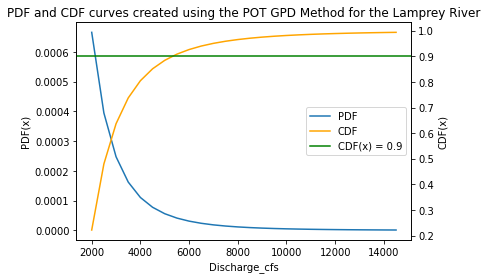

In [97]:
GPDoutputL[3]

Figure 5. PDF and CDF curves created using the POT GPD method are displayed for the Lamprey River. The PDF curve shows that large flood events, such as a discharge of 12,000 cfs, have a low probability of happening, while low discharge values close to 2,000 cfs, have a higher likelihood of taking place. Around 90% of flood events have a discharge less than 5,500 cfs as shown by the CDF curve.

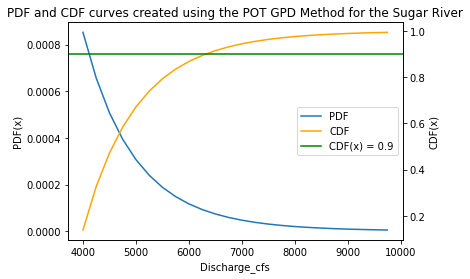

In [98]:
GPDoutputS[3]

Figure 6. PDF and CDF curves created using the POT GPD method are displayed for the Sugar River. The PDF curve shows that large flood events, such as a discharge of 9,000 cfs, have a low probability of happening, while low discharge values close to 4,000 cfs, have a higher likelihood of taking place. Around 90% of flood events have a discharge less than 6,300 cfs as shown by the CDF curve.

In [99]:
#%%Create 2 dataframes: one for lamprey and other for Sugar to display results for all 3 disrtibutions
dfL = dfinterpL.merge(GPDoutputL[0], how = 'outer', on = ['Return Period (yrs)', 'EP', '1 - EP'])
dfL = dfL.drop(columns = ['1 - EP'])
#Include a column of FEMA estimates for the Lamprey River
dfL['FEMA'] = (np.nan, np.nan, np.nan, 4720, np.nan, 7990, 9740, np.nan, 14900, np.nan)
 
#Sugar
dfS = dfinterpS.merge(GPDoutputS[0], how = 'outer', on = ['Return Period (yrs)', 'EP', '1 - EP'])
dfS = dfS.drop(columns = ['1 - EP'])
#Inlcude FEMA estimates in table for Sugar
dfS['FEMA'] = [np.nan, np.nan, np.nan, 7252, np.nan, 10417, 13028, np.nan, 18200, np.nan]


C:\Users\Lauren\anaconda3\envs\projectenv\lib\site-packages\pandas\core\reshape\merge.py:1204: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


In [100]:
print("Lamprey River:")
print(dfL)

Lamprey River:
                         EP        GEV    Gumbel        GPD     FEMA
Return Period (yrs)                                                 
1.5                  0.6667   1718.288  1809.856        NaN      NaN
2.0                  0.5000   2117.773  2348.629   2553.193      NaN
5.0                  0.2000   3352.466  3674.273   3958.312      NaN
10.0                 0.1000   4415.784  4551.965   5307.495   4720.0
25.0                 0.0400   6124.279  5660.931   7577.343      NaN
50.0                 0.0200   7721.521  6483.625   9756.832   7990.0
100.0                0.0100   9652.910  7300.244  12436.355   9740.0
200.0                0.0050  11994.612  8113.884  15730.634      NaN
500.0                0.0020  15876.812  9187.327  21272.892  14900.0
1000.0               0.0010  19553.994  9998.610  26594.517      NaN


Table 5. Displays the results of the flood frequency analysis performed on the Lamprey River using the GEV, Gumbel, and GPD methods. Units are in cfs for the discharge values. The 1.5-year flood was not calculated using the GPD method, as that magnitude was set as the threshold in the analysis. There is some variation between discharge estimates for each method. There were larger discrepancies between discharge values for larger return periods, seen as Gumbel estimated the 1000-year flood as 9998.6 cfs while the GPD estimate was much higher at 26,594.5 cfs. GDP estimated the largest discharges. Gumbel predicted larger discharges than GEV for flood return periods smaller or equal to 10-years, after which the GEV method predicted larger discharges. Discharge estimates calculated by FEMA are shown in the last column.

In [101]:
print("Sugar River:")
print(dfS)

Sugar River:
                         EP        GEV     Gumbel        GPD     FEMA
Return Period (yrs)                                                  
1.5                  0.6667   3849.042   3923.559        NaN      NaN
2.0                  0.5000   4497.835   4663.895   4556.839      NaN
5.0                  0.2000   6289.935   6485.480   5540.266      NaN
10.0                 0.1000   7647.931   7691.529   6322.046   7252.0
25.0                 0.0400   9587.482   9215.374   7408.202      NaN
50.0                 0.0200  11207.428  10345.850   8271.647  10417.0
100.0                0.0100  12986.098  11467.978   9172.841  13028.0
200.0                0.0050  14945.307  12586.012  10113.435      NaN
500.0                0.0020  17849.338  14061.045  11420.236  18200.0
1000.0               0.0010  20313.305  15175.841  12459.084      NaN


Table 6. Displays the results of the flood frequency analysis performed on the Sugar River using the GEV, Gumbel, and GPD methods. Units are in cfs for the discharge values. There are smaller discrepancies between discharges for smaller return periods. GPD estimated smaller discharges than GEV and Gumbel, except for the 2-year flood. GEV and Gumbel had very similar estimates until the 100-year flood, when their estimates started to differ by around 2,000 - 3,000 cfs. Discharge estimates calculated by FEMA are shown in the last column.

In [102]:
#%%Create figure to display return period vs discharge for the methods used before.
def plotfunc(df1, df2, df3, i):
    fig2, ax1 = plt.subplots(figsize = (15,15))
    ax1.scatter(df1['Return Period'], df1['discharge_cfs'], label = 'POT Data', color  = 'r')
    ax1.scatter(df3['Return Period'], df3['annual_discharge_cfs'], label = 'Annual Data', color = 'c')
    ax1.plot(df2.index, df2['GEV'], label = 'GEV')
    ax1.plot(df2.index, df2['Gumbel'], label = 'Gumbel')
    ax1.plot(df2.index, df2['GPD'], label = 'GPD')
    ax1.set_ylabel('Discharge (cfs)')
    ax1.set_xlabel('Return Period (yrs)')
    #plt.xlim([0,1100])
    ax1.set_title('Comparison of Methods with Discharge Data for ' + rivers[i])
    ax1.legend()
    plt.show()


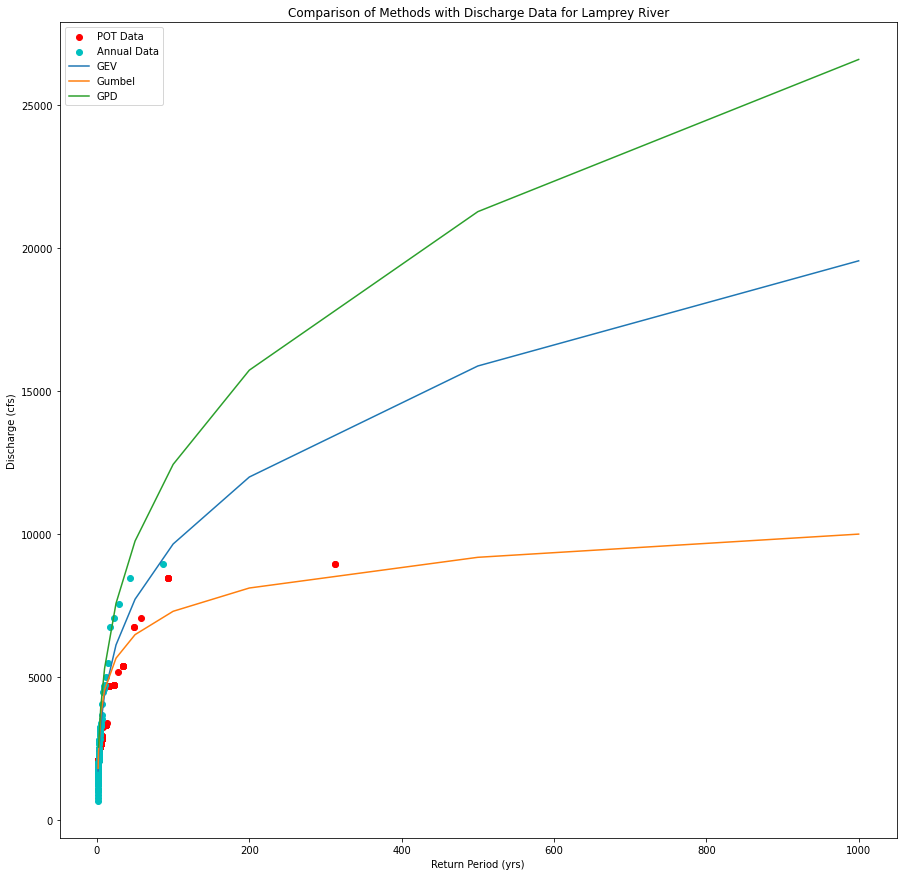

In [103]:
plotfunc(GPDoutputL[4], dfL, dfannualL, 0)

Figure 7. Comparison of discharge predictions determined from the three different method calculated earlier, as well as, discharge data plotted using Weibull plotting position equation for the Lamprey River. For the Lamprey River, GPD produced the highest estimates overall, followed by GPD, than Gumbel. The annual maximum data seems to best fit the curves for the GEV and GPD distribution, while the Gumbel method best matches the POT data. 

This chart displays a major difficulty in predicting magnitudes for floods with very large return periods, being that there are few examples recorded in the data of these large flood events. All three distributions seem to fit the recorded data well, particularly the Gumbel distribution which is fits the data when including the large outlier displayed with a return period of about 300-years. But when looking beyond the recorded data it is unclear which distribution best predicts the larger flood magnitudes associated with the 500-year and 1000-year flood events. 

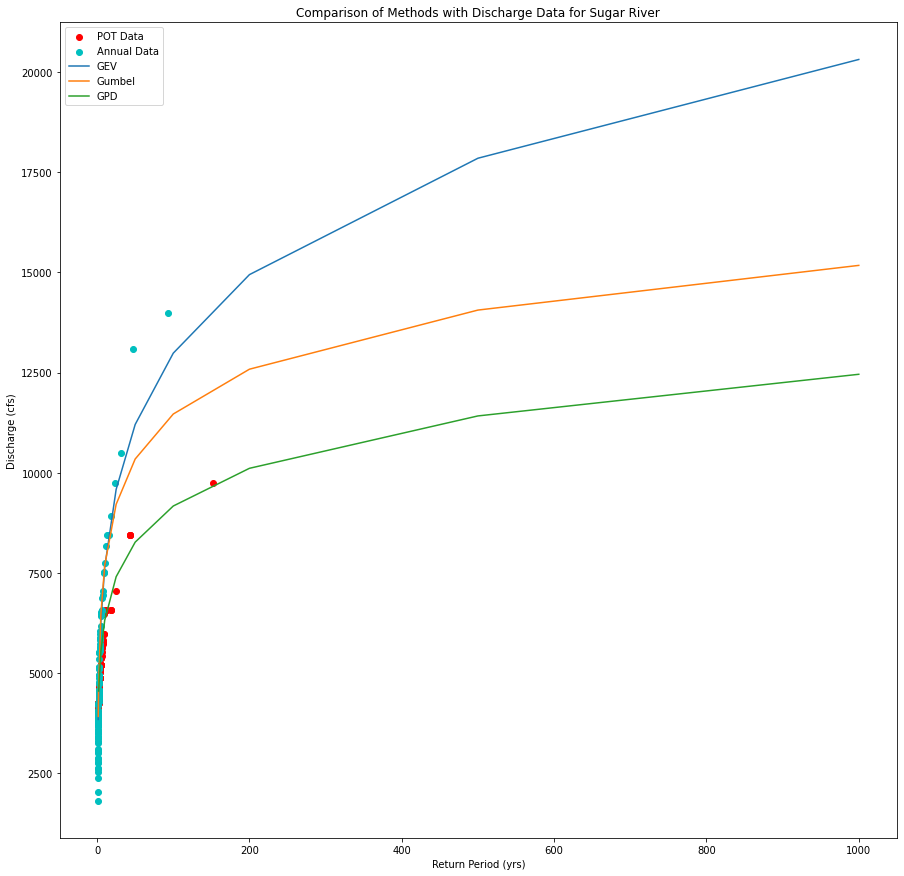

In [104]:
plotfunc(GPDoutputS[4], dfS, dfannualS, 1)

Figure 8. Comparison of discharge predictions determined from the three different method calculated earlier, as well as, discharge data plotted using Weibull plotting position equation for the Sugar River. For the Sugar River the GEV method estimated the largest discharges, followed by the Gumbel distribution, then the GDP method. The GEV method appears to best fit the GEV method, and the POT data is best fit by the GPD method. The Gumbel method estimates values in between these two data sets. As stated before when discussing the results for the Lamprey River, it is hard to gauge the accuracy of the estimates for the 200-year, 500-year and 1000-year flood magnitudes given there are no recorded events larger than the 200-year flood.

### 5.0 Discussion and Conclusion

Overall, there is variation between the discharges estimated by each method (Figure 5; Figure 6). There are also inconsistencies between which methods predict the highest and lowest discharges between the Lamprey and Sugar Rivers (Figure 7; Figure 8). This is consistent with past work that has suggested that some distributions fit some data sets better than others (Gharib et al., 2017). More investigation would be necessary to determine what characteristics of each watershed contribute to certain distributions better fitting the data. Both rivers have a similar climate, watershed size, and both are regulated, so those factors are unlikely to contribute to the distributional differences in the data. It is expected that there is some uncertainty associated with all flood frequency analysis techniques which needs to be considered when using the results of any flood frequency analyses (Collet et al., 2017). To better understand error associated with these estimates, confidence intervals for each method should be calculated (Stedinger et al., 1993). This would be beneficial to gauge the accuracy of the results presented in this study.

The results of this study were compared with FEMA estimates for 10-, 50-, 100-, and 500-year flood magnitudes for the Lamprey and Sugar River. In 2021, FEMA completed a flood frequency analysis on the Lamprey river using the Log-Pearson Type III distribution on annual maximum data from the USGS stream gauge no. 01073500. This analyses determined the 10-year, 50-year, 100-year, and 500-year flood magnitudes to be 4,720 cfs, 7,990 cfs, 9,740 cfs, and 14,900 cfs, respectively (FEMA, 2021). In 2006, FEMA completed a flood frequency analysis on the Sugar River at the location of the gauge used in this project using the Log-Pearson Type III distribution. The results of this analysis determined the 10-year, 50-year, 100-year, and 500-year flood magnitudes to be 7,252 cfs, 10,417 cfs, 13,028 cfs, and 18,200 cfs, respectively (FEMA, 2006). The results of the FEMA study are within 1000 cfs to 2000 cfs for most of the discharge values estimated in this project helping to validate the results of this study (Table 5; Table 6).

There are many ways error can be introduced into a flood frequency analyses. Errors can be caused by faults in individual measurements within the raw data, in threshold selection, and in how the entire data set is measured and analyzed. The raw data should be checked for errors and inconsistencies in the data record, in the case of this study were accounted for using interpolation between small gaps in the record. Threshold selection is very important for the POT GPD method and results can vary greatly depending on the method selected (Pan and Rahman, 2021; Bezak, 2017). The method of peak detection can also have a large impact on what discharge values are included in the analysis (Figure 3; Figure 4). Error can also be caused in part due to the small sample size of extreme events, particularly events above the 100-year flood magnitude. In the future further analysis should be completed on these data sets by calculating confidence intervals for the discharge estimates. More work could be done on this data set, including using different methods of flood frequency analysis, such as using MLE or MOM estimators and different distributions, such as Log-Pearson Type III, in order to determine the best technique for flood frequency analyses on the Lamprey and Sugar Rivers and to further validate the findings of this project.

Another issue to consider when assessing the accuracy of the estimates produced in a flood frequency analysis is if the record is stationary and unregulated. A stationary and unregulated record means that there was no change in location of the gauge or artificial change in discharge that could be caused by additions of dams, or other infrastructure that impacts flow. A non-stationary record or regulated discharge can greatly impact the accuracy of a flood frequency analysis. A non-stationary record may lead to over or under estimation of discharges due to a change in how discharge is recorded. In these cases, it is best to determine when changes in the record take place, and only perform analysis in sections that are stationary.

Another factor that impacts the accuracy of flood frequency analysis estimates is climate change (Collet et al., 2017). Flood frequency analyses are based on historic data which may not represent what will happen in the future if climate change is causing more or less precipitation. If discharge magnitudes increase over the next 100-years, using the past 100-years with lower discharge levels to estimate flood discharges will lead to underestimation of flood magnitudes. For example, what may have been a 100-year flood fifty years ago could have a return interval of 25 years in the present day, which would not be predicted using historic data.

In conclusion, flood frequency analyses were performed on the Lamprey and Sugar rivers using both annual maximum data using GEV and Gumbel distributions, and with instantaneous data with the POT GPD method. Results were validated through comparison to FEMA flood discharge estimates for both rivers. The results of this study were found to be similar to the FEMA discharge estimates suggesting the discharge estimates in the study are reasonable. The discharge values found in the study for the 2-, 5-, 10-, 25- , 50-, 100-, 200- , 500-, and 1000-years floods can be used to determine floodplains, for guidance in building infrastructure around the rivers, and for future research on the rivers.


### 6.0 References

Bezak, N., Brilly, M., Šraj, M., 2014, Comparison between the peaks-over-threshold method and the annual maximum method for flood frequency analysis: Hydrological Sciences Journal, 59:5, 959-977, DOI: 10.1080/02626667.2013.831174

Collet, L., Beevers, L., Prudhome, C., 2017, Assessing the Impact of Climate Change and Extreme Value Uncertainty to Extreme Flows across Great Britain: Water, 9(2), 103. https://doi.org/10.3390/w9020103

FEMA, 2021, Flood Insurance Study Rockingham County, New Hampshire (All Jurisdictions), Vol 1.

FEMA, 2006, Flood Insurance Study Sullivan County, New Hampshire (All Jurisdictions), Vol 1.

Gharib, A., Davies, E.G.R., Goss, G.G., Faramarzi, M., 2017, Assessment of the Combined Effects of Threshold Selection and Parameter Estimation of Generalized Pareto Distribution with Applications to Flood Frequency Analysis: Water, 9, 692. https://doi.org/10.3390/w9090692

Pan, X., Rahman, A., 2021, Comparison of Annual Maximum and Peaks Over Threshold Methods with Automated Threshold Selection in Flood Frequency Analysis: A Case Study for Australia. 10.21203/rs.3.rs-216479/v1.

Stedinger, J.R., Vogel, R.M., Foufoula-Gcorgiou, E., 1993, Frequency analysis of extreme events: Handbook of Hydrology, New York, McGraw-Hill, ch. 18.

Wymore, A.S., Shattuck, M.D., Potter, J.D., Snyder, L., McDowell, W.H., 2021, The Lamprey River Hydrological Observatory: Suburbanization and changing seasonality: Hydrological Processes, 35, e14131. https://doi.org/10.1002/hyp.14131
